In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import HeatMap

import funcoes

In [2]:
parcial_path_absolute = Path.home() / 'OneDrive' / 'Documentos' / 'GitHub'
parcial_path_relative = Path('analise_dados_crimes_seattle')
full_path = parcial_path_absolute / parcial_path_relative

absolute_path_data_raw = full_path / 'data' / 'raw'
absolute_path_data_processed = full_path / 'data' / 'processed'

path_data = absolute_path_data_processed / 'SPD_Crime_data_cleaned.csv'

path_data_population = absolute_path_data_raw / 'population.xlsx'

In [3]:
df_population = pd.read_excel(path_data_population)

In [4]:
px.line(df_population, x='year', y='population')

In [5]:
# selecionar dados de 2017 até 2024 => tamanho da população com variação de aproximadamente 3,5%

In [6]:
df = pd.read_csv(path_data)
dff = df.copy()

In [7]:
# 'report datetime'
dff['report datetime'] = funcoes.transformando_colunas_em_datetime(dff, 'report datetime')

# 'offense date
dff['offense date'] = funcoes.transformando_colunas_em_datetime(dff, 'offense date')

c:\Users\tales\OneDrive\Documentos\GitHub\analise_dados_crimes_seattle\src\funcoes\__init__.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

c:\Users\tales\OneDrive\Documentos\GitHub\analise_dados_crimes_seattle\src\funcoes\__init__.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [8]:
dff['hour'] = dff['offense date'].apply(lambda x: x.hour)
dff['minute'] = dff['offense date'].apply(lambda x: x.minute)
dff['day_of_week'] = dff['offense date'].apply(lambda x: x.day_of_week)
dff['month'] = dff['offense date'].apply(lambda x: x.month)
dff['year'] = dff['offense date'].apply(lambda x: x.year)

# Definindo a função para categorizar os períodos do dia
def categorizar_periodo(hora):
    if 0 <= hora < 6:
        return 'Madrugada (0-6h)'
    elif 6 <= hora < 12:
        return 'Manhã (6-12h)'
    elif 12 <= hora < 18:
        return 'Tarde (12-18h)'
    else:
        return 'Noite (18-24h)'


# Aplicando a função à coluna 'hour'
dff['periodo'] = dff['hour'].apply(categorizar_periodo)

In [9]:
dff_eda = dff.copy()

In [10]:
# filtrando ano
dff_eda = dff_eda[(dff_eda['year']>=2016) & (dff_eda['year']<2025)]

In [11]:
dff_eda.head(1)

,report number,report datetime,offense id,offense date,nibrs group ab,nibrs crime against category,offense sub category,shooting type group,beat,precinct,...,nibrs offense code description,nibrs_offense_code,longitude,latitude,hour,minute,day_of_week,month,year,periodo
6,2022-018278,2022-01-22 21:12:40,31345377632,2022-01-22 19:20:00,B,SOCIETY,TRESPASS,-,Q3,West,...,Trespass of Real,90J,0.0,0.0,19,20,5,1,2022,Noite (18-24h)


In [12]:
dff_eda.columns

Index(['report number', 'report datetime', 'offense id', 'offense date',
       'nibrs group ab', 'nibrs crime against category',
       'offense sub category', 'shooting type group', 'beat', 'precinct',
       'sector', 'offense category', 'nibrs offense code description',
       'nibrs_offense_code', 'longitude', 'latitude', 'hour', 'minute',
       'day_of_week', 'month', 'year', 'periodo'],
      dtype='object')

## Análise Exploratória (EDA)

### Estatística Descritiva

#### Frequência de tipos de crimes

In [13]:
# contagem por nibrs group ab
dff_eda['nibrs group ab'].value_counts(normalize=True)

nibrs group ab
A    0.85334
B    0.14666
Name: proportion, dtype: float64

In [14]:
# 86.56% | Grupo A: inclui crimes mais graves
# 13.44% | Grupo B: inclui infrações de menor gravidade

In [15]:
# contagem por nibrs crime against category
dff_eda['nibrs crime against category'].value_counts(normalize=True)

nibrs crime against category
PROPERTY    0.669129
PERSON      0.157994
ANY         0.087409
SOCIETY     0.085469
Name: proportion, dtype: float64

In [16]:
# PROPERTY: Cerca de 67,8% dos registros são crimes contra a propriedade (por exemplo, furto, roubo, arrombamento, vandalismo, etc.).
# PERSON: Aproximadamente 16,1% são crimes contra a pessoa (por exemplo, agressão, homicídio, estupro).
# SOCIETY: Cerca de 8,4% são crimes contra a sociedade (por exemplo, porte ilegal de arma, drogas, prostituição, crimes ambientais).
# ANY: Cerca de 7,6% foram classificados como “ANY” (pode ser um rótulo genérico ou casos em que o sistema não conseguiu classificar de forma mais específica).

## insights iniciais
# Prioridades de policiamento: Se quase 70% dos registros são crimes contra propriedade, políticas de prevenção (iluminação, policiamento ostensivo em áreas de furtos/roubos, conscientização sobre proteção de veículos e imóveis) podem ser reforçadas.
# Alocação de recursos: A parcela expressiva de crimes contra a pessoa (16%) demanda estratégias específicas (por exemplo, patrulhas em horários de maior incidência, programas de redução de violência doméstica, acompanhamento de reincidentes).
# Políticas de controle social: Parte dos crimes contra a sociedade (8,4%) pode exigir abordagens diferentes, como combate ao tráfico de drogas, medidas educativas ou mudanças na legislação local.

In [17]:
# contagem por nibrs crime against category
dff_eda['offense sub category'].value_counts(normalize=True).head(10)

offense sub category
LARCENY-THEFT                                            0.319983
BURGLARY                                                 0.106060
ASSAULT OFFENSES                                         0.095854
PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)         0.091239
ALL OTHER                                                0.087409
MOTOR VEHICLE THEFT                                      0.069018
EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD CHECKS)    0.060754
AGGRAVATED ASSAULT                                       0.036106
TRESPASS                                                 0.033974
ROBBERY                                                  0.020186
Name: proportion, dtype: float64

In [18]:
# ~43% dos crimes se dividem em LARCENY-THEFT (32.1%) e BURGLARY (10.8%)

# LARCENY-THEFT: corresponde a quase 1/3 de todos os registros. Isso reforça a ideia de que crimes contra a propriedade são comuns no dataset. 
## Inclui crimes de furto, geralmente sem uso de força ou violência direta contra a vítima (por exemplo, furtos em lojas, roubos de objetos em veículos destrancados, etc.).

# BURGLARY: corresponde a quase 11% dos casos, envolvendo invasão de imóveis (residências, estabelecimentos) para cometer furto ou outro delito. 
## Também se enquadra em crimes contra a propriedade

In [19]:
# verificando crimes "ALL OTHER"
dff_eda[dff_eda['offense sub category']=='ALL OTHER']['nibrs group ab'].value_counts()

nibrs group ab
B    64153
Name: count, dtype: int64

In [20]:
dff_eda[dff_eda['offense sub category']=='ALL OTHER']['nibrs crime against category'].value_counts()

nibrs crime against category
ANY    64153
Name: count, dtype: int64

In [21]:
dff_eda = dff_eda[dff_eda['offense sub category']!='ALL OTHER']

In [22]:
# Descartar já que não existe informação nenhuma sobre os crimes e todos eles se encaixam no grupo de menor gravidade (B)

#### Distribuição por dia da semana, mês, hora do dia

<Axes: >

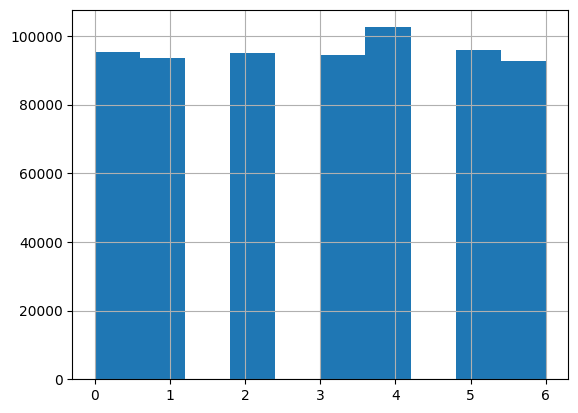

In [23]:
# dia da semana
dff_eda['day_of_week'].hist()

In [24]:
# distribuição ilustra que não temos muita variação por dia da semana

In [25]:
# mês
dff_eda['month'].value_counts(normalize=True)

month
5     0.093088
10    0.087578
8     0.087166
7     0.087031
9     0.083986
1     0.083292
12    0.081983
11    0.081905
3     0.081792
4     0.079777
6     0.079307
2     0.073095
Name: proportion, dtype: float64

In [26]:
px.bar(dff_eda.groupby('month').agg({'offense id':'count'}).reset_index(), x='month', y='offense id')

In [27]:
# hora do dia
dff_eda['hour'].value_counts(normalize=True)

hour
0     0.099566
12    0.055777
18    0.053977
17    0.053972
20    0.052514
19    0.049551
22    0.049163
21    0.048491
16    0.048339
15    0.046879
14    0.042431
23    0.042364
13    0.041212
11    0.037630
10    0.036099
8     0.034399
9     0.034090
1     0.033887
2     0.028140
7     0.024842
3     0.023708
4     0.021962
6     0.021099
5     0.019906
Name: proportion, dtype: float64

In [28]:
# identificação de outliers, possíveis erros em dados
dff_eda = dff_eda[(dff_eda['hour']!=0) & (dff_eda['minute']!=0)]

In [29]:
dff_eda['hour'].value_counts(normalize=True)

hour
17    0.056503
16    0.056425
15    0.055377
18    0.055053
20    0.053995
19    0.053441
12    0.052952
14    0.052364
13    0.051730
21    0.051081
22    0.047313
11    0.047259
23    0.045076
10    0.042007
9     0.038391
1     0.037566
8     0.035915
2     0.032762
7     0.030090
3     0.027771
4     0.027197
6     0.024995
5     0.024738
Name: proportion, dtype: float64

In [30]:
px.bar(dff_eda.groupby('periodo').agg({'offense id':'count'}).reset_index(), x='periodo', y='offense id')

In [31]:
# a maior parte dos crimes ocorrem entre 12h - 24h
# no período da "madrugada" temos um número menor de reports, sugerindo que a força policiar deve ser priorizada para os horários de 12h em diante.

#### Tendências de aumento ou diminuição ao longo do tempo.

In [32]:
dff_por_cem_mil = pd.merge((dff_eda.groupby('year').agg({'offense id':'count'}).reset_index()), (df_population), how='left', on='year')
dff_por_cem_mil['taxa'] = round(((dff_por_cem_mil['offense id'] / dff_por_cem_mil['population']) * 100000), 2)

In [33]:
px.line(dff_por_cem_mil, x='year', y='taxa')

In [34]:
# tendência de queda com instabilidade entre 2020 - 2022
# pandemia pode ter impacto para a interferência na tendência de queda?

### Visualizações

#### Gráficos de linhas para evoluções temporais

In [35]:
px.line(funcoes.df_filtrado_taxa_cem_mil(dff_eda, df_population, 'nibrs crime against category', 'PROPERTY'), x='year', y='taxa')

In [36]:
# Para crimes cometidos contra a propriedade observa-se comportamento semelhante aos dados completos.
# 

In [37]:
px.line(funcoes.df_filtrado_taxa_cem_mil(dff_eda, df_population, 'nibrs crime against category', 'PERSON'), x='year', y='offense id')

In [38]:
px.line(funcoes.df_filtrado_taxa_cem_mil(dff_eda, df_population, 'nibrs crime against category', 'SOCIETY'), x='year', y='offense id')

In [39]:
# O comportamento das linhas sugerem que os dados estavam caindo porém no período de 2020-2022, essa queda foi substituída por um aumento de crimes contra Propriedade.
# para crimes contra pessoa, tivemos uma queda brusca no ano de 2020 (auge da pandemia). entre 2020 - 2022 um aumento significativo foi observado, com o número voltando a estabilizar (queda).

In [40]:
px.line(dff_eda.groupby(['year','offense sub category']).agg({'offense sub category':'count'}).rename({'offense sub category':'cat'},axis=1).reset_index(), x='year', y='cat', color='offense sub category')

#### Gráficos de barras para comparar tipos de crimes mais frequentes.

In [41]:
df_tipos_de_crimes_count = dff_eda['offense sub category'].value_counts().to_frame().reset_index()

In [42]:
df_tipos_de_crimes_count.head(10)

,offense sub category,count
0,LARCENY-THEFT,135869
1,ASSAULT OFFENSES,54905
2,"PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)",43247
3,BURGLARY,42655
4,TRESPASS,21316
5,AGGRAVATED ASSAULT,21209
6,MOTOR VEHICLE THEFT,19091
7,EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD ...,17138
8,ROBBERY,12225
9,NARCOTIC VIOLATIONS (INCLUDES DRUG EQUIP.),10671


In [43]:
df_tipos_de_crimes_count['count'].describe().to_frame().reset_index()[df_tipos_de_crimes_count['count'].describe().to_frame().reset_index()['index']=='75%']['count']

6    18602.75
Name: count, dtype: float64

In [44]:
px.bar(df_tipos_de_crimes_count[df_tipos_de_crimes_count['count']>=18602], x='offense sub category', y='count')

#### Mapas de calor (heatmaps) ou choropleth maps para visualizar concentração de crimes por região.

In [45]:
dff_eda_map = dff_eda[~dff_eda['latitude'].isna()]
dff_eda_map = dff_eda_map[dff_eda_map['latitude']!=0]

In [ ]:
# Centraliza o mapa pela média das coordenadas
mapa = folium.Map(location=[test['latitude'].mean(), test['longitude'].mean()], zoom_start=12)

# Prepara os dados para o heatmap: uma lista de listas contendo [latitude, longitude]
heat_data = test[['latitude', 'longitude']].values.tolist()

# Adiciona o heatmap ao mapa
HeatMap(heat_data).add_to(mapa)

# Exibe o mapa no notebook
mapa


### Identificação de padrões e correlações

#### Correlacionar variáveis como hora do dia e tipo de crime.

#### verificar a influência de fatores externos (clima, eventos da cidade, período de férias escolares etc.).

### Formulação de hipóteses

#### “Crimes de furto de veículos aumentam em determinadas regiões durante a madrugada?”.

#### “Há correlação entre índices de desemprego ou renda e certos tipos de crimes?”.

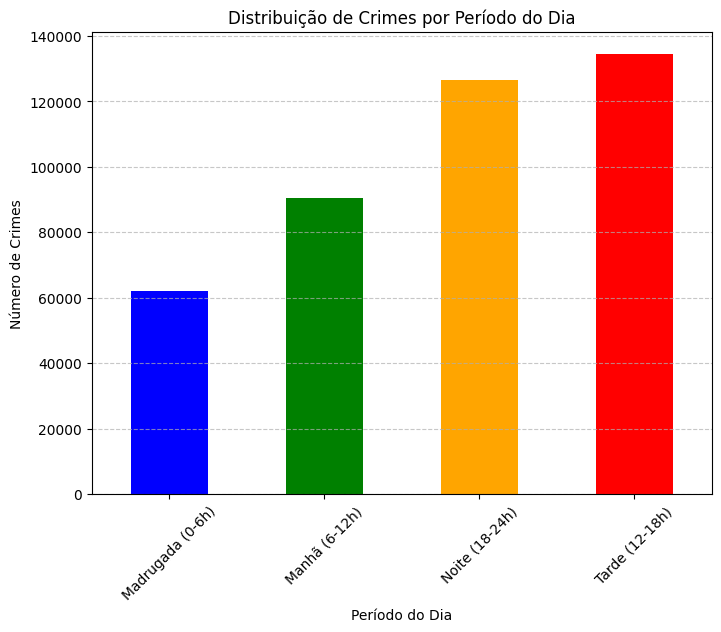

In [ ]:
# Contagem de crimes por período
crime_por_periodo = dff_eda['periodo'].value_counts().sort_index()



# Criando gráfico para visualizar os períodos de maior risco
plt.figure(figsize=(8, 6))
crime_por_periodo.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Período do Dia")
plt.ylabel("Número de Crimes")
plt.title("Distribuição de Crimes por Período do Dia")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


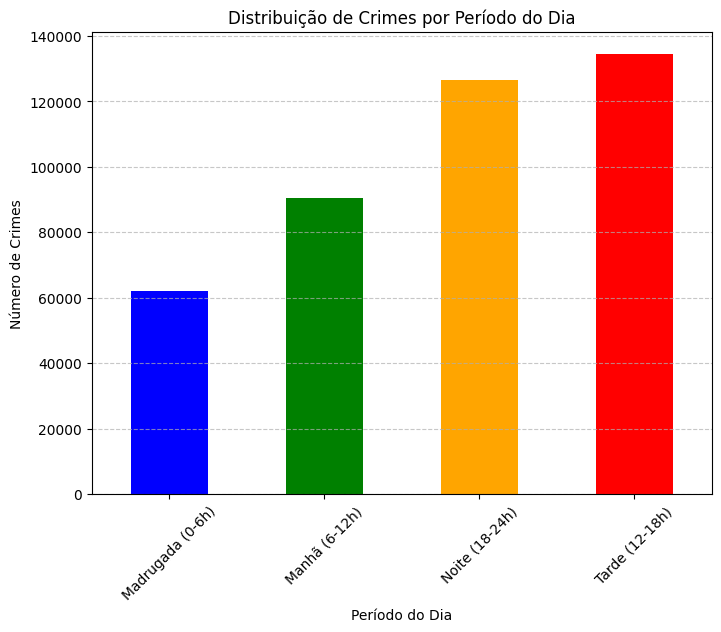

In [ ]:
# Contagem de crimes por período
crime_por_periodo = dff_eda['periodo'].value_counts().sort_index()



# Criando gráfico para visualizar os períodos de maior risco
plt.figure(figsize=(8, 6))
crime_por_periodo.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Período do Dia")
plt.ylabel("Número de Crimes")
plt.title("Distribuição de Crimes por Período do Dia")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
